In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [18,5]
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# min-max scaler
from sklearn.preprocessing import MinMaxScaler

### Initialization

In [2]:
# read clean electricity data to create target variable array y
elec = pd.read_csv('../data/elec_clean.csv',index_col=0)
elec.index = pd.to_datetime(elec.index,format='%Y-%m-%d %H:00:00')

# remove Davenport for now because it is missing most of June and July
elec.drop('Davenport',axis=1,inplace=True)

# agg = pd.DataFrame({'actual':elec.sum(axis=1)})
aggregate = pd.Series(elec.sum(axis=1))

### Transform the training data

The neural network will perform better on stationary data. Electricity demand data is never stationary, because it includes seasonal (daily, weekly, yearly) and trend (steady/exponential increase) effects. The following cells make the data stationary by calculating and then removing the hour-of-week (weekend vs weekday) and week-of-year (spring break vs class in session) effects.

Then, a min-max scaler will be applied for the stationary data so the lag features and date features can be compared directly. It is reasonable to scale over the entire range of data, because in a more realistic scenario, multiple years of data would be analyzed, and the previous year could be used for scaling.

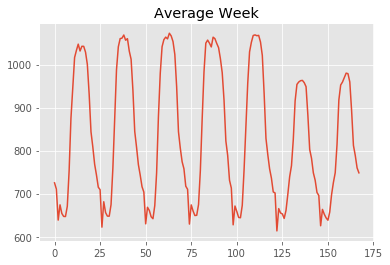

In [3]:
# calculate hour-of-week and week-of-year averages to isolate weekend, holiday median-shifting
hourofweekarray, hourofweek = range(168),range(1,168) # 2018 starts on a thursday
while len(hourofweek) < 10000: hourofweek = np.append(hourofweek,hourofweekarray)
hourofweek = hourofweek[:4991]

avg_week = aggregate.groupby(hourofweek).mean()
aggregate_week_transformer = np.vectorize(avg_week.to_dict().get)(hourofweek)
avg_year = aggregate.groupby(aggregate.index.weekofyear).mean()
aggregate_year_transformer = aggregate.index.weekofyear.map(avg_year)
aggregate_stationary = aggregate/aggregate_week_transformer/aggregate_year_transformer

# plot the average week
avg_week.plot(title="Average Week")

### Forecasting with Recurrent Neural Networks

This notebook implements multi-step forecasting using a neural network. The following cell prepares the data for the neural network. X includes the previous 168 hourly values (one week of data) and 9 calendar features for an input dimension of 177. The output, y, includes 39 forecasted values for the target day.

This cell is annoyingly slow right now. I believe the method I use to populate X and y is extremely inefficient. Fixing it is a necessary improvement for larger datasets.

In [4]:
# training length params
all_days = pd.date_range(pd.to_datetime('2018-01-10 09:00:00'),pd.to_datetime('2018-7-10 09:00:00'),freq='D')

# names for columns
X_cols = ['t-'+str(i) for i in range(1,169)]
y_cols = ['t+'+str(i) for i in range(0,39)]

# create dataframes structured for multi-step batch input
X = pd.DataFrame(index=all_days,columns=X_cols)
y = pd.DataFrame(index=all_days,columns=y_cols)

# populate dataframes with electricity loads
for i in all_days:
    for j in range(168):
        X.loc[i,X_cols[j]] = aggregate_stationary[i-pd.Timedelta(hours=j)]
    for k in range(39):
        y.loc[i,y_cols[k]] = aggregate_stationary[i+pd.Timedelta(hours=k)]

# day of week features
days = ['mon','tues','wed','thurs','fri','sat','sun']
for i in range(7):
    X[days[i]] = (np.array([i]*len(X))==np.asarray(X.index.dayofweek)).astype(int)

# feature for school breaks
X['break'] = (X.index.isin(pd.date_range(start='01/01/2018',end='01/15/2018',freq='H'))
              |X.index.isin(pd.date_range(start='03/10/2018',end='03/25/2018',freq='H'))
              |X.index.isin(pd.date_range(start='05/10/2018',end='08/22/2018',freq='H'))
             ).astype(int)

# feature for office holidays: MLK day, memorial day, 4th of july
X['holiday'] = (X.index.isin(pd.date_range(start='01/15/2018',end='01/16/2018',freq='H'))
                |X.index.isin(pd.date_range(start='05/28/2018',end='05/29/2018',freq='H'))
                |X.index.isin(pd.date_range(start='07/04/2018',end='07/05/2018',freq='H'))
               ).astype(int)

# force floats for all values
X = X.astype(float)
y = y.astype(float)

# scale from 0 to 1, so lag features and date features are on the same scale
X_scaler = MinMaxScaler().fit(X)
y_scaler = MinMaxScaler().fit(y)
X_scaled = pd.DataFrame(data=X_scaler.transform(X),index=X.index,columns=X.columns)
y_scaled = pd.DataFrame(data=y_scaler.transform(y),index=y.index,columns=y.columns)

In [5]:
# build the model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=177))
model.add(Dense(39))
model.compile(optimizer='adam', loss='mse')

This cell starts at the starting_day and trains a new model for each day

For each day in testing_days, this cell trains using all available data and predicts for the following day. Then, each daily forecast is added to the forecasts dataframe for comparison to the actual data. The model can either reinitialized during each loop, or continually trained during each test. Not sure what effect this will have on the results.

In [6]:
# forecast for each day in the range, store forecasts in forecasts series
forecasts = pd.Series(index = elec.index)
num_days = 10
starting_day = pd.to_datetime('2018-01-11 09:00:00')
test_days = pd.date_range(start=starting_day,periods=num_days,freq='D')

for k in test_days:
    # split data into train and prediction sets
    X_train = X_scaled.loc[:k].values
    y_train = y_scaled.loc[:k].values
    X_pred = X_scaled.loc[k+pd.Timedelta(hours=24)].values.reshape(1,177)
    
    # redefine the model (optional)
#     model = Sequential()
#     model.add(Dense(100, activation='relu', input_dim=177))
#     model.add(Dense(39))
#     model.compile(optimizer='adam', loss='mse')
    
    # fit the model and make a prediction
    model.fit(X_train, y_train, epochs=1000, verbose=0)
    y_pred = model.predict(X_pred,verbose=0)
    
    # reverse the MinMaxScaler
    y_pred = y_scaler.inverse_transform(y_pred.reshape(1,-1))
    
    # store the prediction
    forecast = y_pred.reshape(39,)[15:]
    forecasts[k+pd.Timedelta(hours=15):k+pd.Timedelta(hours=38)] = forecast
    
    # optional diagnostics
    print('min: ',forecast.min(),'    ','max: ',forecast.max())

min:  0.0009909202      max:  0.001302079
min:  0.0010278932      max:  0.001323729
min:  0.0011407087      max:  0.0012734648
min:  0.00095329527      max:  0.0012332025
min:  0.0010834142      max:  0.0012703743
min:  0.0010806096      max:  0.0012370299
min:  0.0011096633      max:  0.0012843512
min:  0.0011290272      max:  0.0013250207
min:  0.0011781789      max:  0.0013557307
min:  0.0011104386      max:  0.0012314094


4.087124953510117

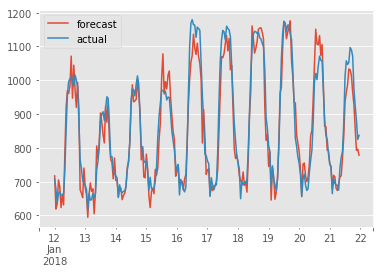

In [7]:
results = pd.DataFrame(index=aggregate_stationary.index)
results['forecast'] = forecasts*aggregate_year_transformer*aggregate_week_transformer
results['actual'] = aggregate.values
results = results[test_days[0]+pd.Timedelta(hours=15):test_days[0]+pd.Timedelta(days=num_days,hours=14)]

results.plot()

mape = np.mean(np.abs((results['actual'] - results['forecast']) / results['actual']))*100
mape

### Full-scale testing

This cell evaluates the model ten times over the entire training set. It likely takes hours to run. It fills a dataframe called forecasts with columns corresponding to each full test.

In [ ]:
# full-scale model parameters
num_days = 180
num_trials = 10

# forecast for each day in the range, store forecasts in forecasts series
forecasts = pd.DataFrame(index = elec.index,columns=['Trial '+str(i) for i in range(num_trials)])
starting_day = pd.to_datetime('2018-01-11 09:00:00')
test_days = pd.date_range(start=starting_day,periods=num_days,freq='D')

for i in range(num_trials):
    print('Trial {} in progress...'.format(i))
    
    # redefine the model
    model = Sequential()
    model.add(Dense(150, activation='relu', input_dim=177))
    model.add(Dense(39))
    model.compile(optimizer='adam', loss='mse')
    
    for k in test_days:
        # split data into train and prediction sets
        X_train = X_scaled.loc[:k].values
        y_train = y_scaled.loc[:k].values
        X_pred = X_scaled.loc[k+pd.Timedelta(hours=24)].values.reshape(1,177)
        
        # redefine the model
        model = Sequential()
        model.add(Dense(150, activation='relu', input_dim=177))
        model.add(Dense(39))
        model.compile(optimizer='adam', loss='mse')

        # fit the model and make a prediction
        model.fit(X_train, y_train, epochs=50, verbose=0)
        y_pred = model.predict(X_pred,verbose=0)

        # reverse the MinMaxScaler
        y_pred = y_scaler.inverse_transform(y_pred.reshape(1,-1))

        # store the prediction
        forecast = y_pred.reshape(39,)[15:]
        forecasts['Trial '+str(i)][k+pd.Timedelta(hours=15):k+pd.Timedelta(hours=38)] = forecast

Trial 0 in progress...
Trial 1 in progress...
Trial 2 in progress...
Trial 3 in progress...


In [ ]:
# build the results dataframe, plot, and calculate mape
results = pd.DataFrame(index=aggregate.index)
for i in range(10):
    results['forecast '+str(i)] = forecasts['Trial '+str(i)]*aggregate_year_transformer*aggregate_week_transformer
results['actual'] = aggregate.values
results['forecast avg'] = results.iloc[:,:num_trials].mean(axis=1)
results = results[test_days[0]+pd.Timedelta(hours=15):test_days[0]+pd.Timedelta(days=num_days,hours=14)]

results[['forecast avg','actual']].plot(figsize=(18,5))

mape = np.mean(np.abs((results['actual'] - results['forecast avg']) / results['actual']))*100
mape

### results log:

First run (180 days, 10 trials, stateful model for each trial): 3.961
